In [300]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

# Define constants

In [2]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Define helpful functions

In [3]:
def calc_pot_temp(T, p):
    p_0 = 1000.0
    c_p = 1005.0
    R = 287.0

    pot_temp = (T+273.15)*(p_0/p)**(R/c_p)
    return pot_temp

# Read merged meterological & foehn data

In [4]:
df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])
# df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z") # Only if reading from Dataiku file
df_ERA.dropna(inplace=True)
df_ERA.reset_index(inplace=True, drop=True)

# Use only features which are also in CESM and which are not in the Alps

In [5]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [6]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [7]:
df_ERA

,Z_4287_1500_500,T_4476_1500_850,V_4759_250_700,U_4476_1500_700,Z_4664_0_700,U_4287_125_700,V_4853_375_500,T_4947_125_850,U_4476_1125_850,U_4570_375_500,...,SLP_4476_125_sealevel,U_4287_1125_500,T_4287_625_500,T_4853_0_850,T_4476_875_700,U_4947_1375_500,T_4382_1250_900,V_4947_750_700,T_4570_1375_500,Foehn
0,5550.312012,5.226111,5.970682,1.672275,2966.101562,8.593506,7.310210,3.042254,2.731376,2.851371,...,1013.079773,3.330022,-19.266531,1.756798,-4.239148,-13.110638,9.199698,5.174842,-21.254044,0.0
1,5554.794434,4.791711,6.791761,0.930714,2977.389160,7.333842,6.837455,1.874082,0.751412,2.124057,...,1015.080078,4.661558,-19.367506,1.249335,-4.444261,-12.806551,8.374409,4.030983,-21.575233,0.0
2,5563.737793,4.926731,7.034356,-1.060020,2982.574463,6.042210,8.400747,-0.553009,-0.853114,4.325196,...,1015.932556,8.464959,-18.437632,-0.706255,-5.306575,-13.199444,7.336182,2.148686,-21.927908,0.0
3,5600.050781,5.691738,4.267796,-0.327020,3009.659424,4.116491,10.310655,0.777397,0.574478,2.843172,...,1016.173096,6.994772,-18.767794,1.660222,-3.876113,-9.602874,8.947166,2.637959,-21.596304,0.0
4,5616.816895,6.879436,2.298293,0.612262,3016.617432,2.276925,8.712481,2.338395,0.160351,1.869954,...,1015.445862,7.718970,-19.864586,2.413018,-3.050173,-7.276566,9.486069,3.256030,-21.564968,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54649,5670.972168,7.875871,8.396072,-4.838331,3044.815674,2.572216,4.345853,0.547212,-0.420354,3.634677,...,1019.157471,-0.527913,-22.989643,0.327473,-1.988561,6.531979,9.613852,8.545875,-20.201897,0.0
54650,5666.761230,7.375181,9.550776,-1.183904,3052.439209,5.429709,6.060659,1.128271,-1.122659,0.592725,...,1020.249329,-0.489360,-23.824211,1.244894,-2.556567,8.182809,9.461067,7.204966,-20.813290,0.0
54651,5650.708984,7.362541,1.693947,-2.240282,3036.425293,1.987620,4.206593,3.909623,-1.136518,1.514709,...,1018.498291,0.209052,-23.671337,4.286952,-2.950220,11.233725,8.383458,1.242612,-21.897541,0.0
54652,5654.666504,8.151156,4.969311,-3.851141,3041.532959,0.510079,4.693091,2.800816,-3.589834,3.160478,...,1016.965210,4.672120,-22.403679,3.831559,-3.017481,9.770995,9.799923,0.761001,-22.133310,0.0


# Calculate derived variables

In [8]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)

del SLP_dict

In [9]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)

del df_Z_level, Z_dict

In [10]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)

del df_T, PHIT_dict

In [11]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [12]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [13]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                                 df_pressures, 
                                 df_Z, 
                                 df_PHIT, 
                                 df_stability, 
                                 df_wind], 
                                axis = 1)

# Train Model on full data

In [14]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [15]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [16]:
def fit_clf_on_all_features(model):
    
    # Fit model
    model.fit(df_ERA_all_features.loc[train_mask, feature_names], 
              df_ERA_all_features.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA_all_features.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_all_features.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA_all_features.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA_all_features.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA_all_features.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

0:	learn: 0.5756758	total: 342ms	remaining: 5m 41s
1:	learn: 0.4796577	total: 583ms	remaining: 4m 50s
2:	learn: 0.4136987	total: 832ms	remaining: 4m 36s
3:	learn: 0.3628648	total: 1.08s	remaining: 4m 29s
4:	learn: 0.3258566	total: 1.32s	remaining: 4m 22s
5:	learn: 0.2941602	total: 1.58s	remaining: 4m 21s
6:	learn: 0.2703748	total: 1.82s	remaining: 4m 18s
7:	learn: 0.2539715	total: 2.06s	remaining: 4m 15s
8:	learn: 0.2382048	total: 2.31s	remaining: 4m 14s
9:	learn: 0.2262733	total: 2.63s	remaining: 4m 20s
10:	learn: 0.2129813	total: 2.94s	remaining: 4m 24s
11:	learn: 0.2053029	total: 3.22s	remaining: 4m 24s
12:	learn: 0.1980459	total: 3.46s	remaining: 4m 22s
13:	learn: 0.1912221	total: 3.7s	remaining: 4m 20s
14:	learn: 0.1838964	total: 3.97s	remaining: 4m 20s
15:	learn: 0.1794303	total: 4.23s	remaining: 4m 20s
16:	learn: 0.1759560	total: 4.47s	remaining: 4m 18s
17:	learn: 0.1714200	total: 4.72s	remaining: 4m 17s
18:	learn: 0.1690004	total: 4.95s	remaining: 4m 15s
19:	learn: 0.1667299	to

158:	learn: 0.0875298	total: 42.6s	remaining: 3m 45s
159:	learn: 0.0872551	total: 42.9s	remaining: 3m 45s
160:	learn: 0.0869303	total: 43.2s	remaining: 3m 45s
161:	learn: 0.0865974	total: 43.5s	remaining: 3m 45s
162:	learn: 0.0863603	total: 43.8s	remaining: 3m 44s
163:	learn: 0.0859990	total: 44.1s	remaining: 3m 44s
164:	learn: 0.0856569	total: 44.4s	remaining: 3m 44s
165:	learn: 0.0853783	total: 44.6s	remaining: 3m 44s
166:	learn: 0.0850875	total: 44.9s	remaining: 3m 44s
167:	learn: 0.0848061	total: 45.2s	remaining: 3m 43s
168:	learn: 0.0844821	total: 45.5s	remaining: 3m 43s
169:	learn: 0.0841971	total: 45.7s	remaining: 3m 43s
170:	learn: 0.0838267	total: 46s	remaining: 3m 43s
171:	learn: 0.0835887	total: 46.3s	remaining: 3m 42s
172:	learn: 0.0832436	total: 46.6s	remaining: 3m 42s
173:	learn: 0.0830212	total: 46.9s	remaining: 3m 42s
174:	learn: 0.0827549	total: 47.1s	remaining: 3m 42s
175:	learn: 0.0824438	total: 47.4s	remaining: 3m 41s
176:	learn: 0.0821139	total: 47.7s	remaining: 3m

313:	learn: 0.0578484	total: 1m 23s	remaining: 3m 2s
314:	learn: 0.0577211	total: 1m 23s	remaining: 3m 1s
315:	learn: 0.0576371	total: 1m 23s	remaining: 3m 1s
316:	learn: 0.0575344	total: 1m 24s	remaining: 3m 1s
317:	learn: 0.0574364	total: 1m 24s	remaining: 3m
318:	learn: 0.0573700	total: 1m 24s	remaining: 3m
319:	learn: 0.0573168	total: 1m 24s	remaining: 3m
320:	learn: 0.0571316	total: 1m 25s	remaining: 2m 59s
321:	learn: 0.0570394	total: 1m 25s	remaining: 2m 59s
322:	learn: 0.0569763	total: 1m 25s	remaining: 2m 59s
323:	learn: 0.0568049	total: 1m 25s	remaining: 2m 59s
324:	learn: 0.0567268	total: 1m 26s	remaining: 2m 58s
325:	learn: 0.0566509	total: 1m 26s	remaining: 2m 58s
326:	learn: 0.0565715	total: 1m 26s	remaining: 2m 58s
327:	learn: 0.0565059	total: 1m 26s	remaining: 2m 57s
328:	learn: 0.0563048	total: 1m 27s	remaining: 2m 57s
329:	learn: 0.0561352	total: 1m 27s	remaining: 2m 57s
330:	learn: 0.0559754	total: 1m 27s	remaining: 2m 57s
331:	learn: 0.0557700	total: 1m 27s	remainin

466:	learn: 0.0438676	total: 2m 1s	remaining: 2m 18s
467:	learn: 0.0437582	total: 2m 1s	remaining: 2m 18s
468:	learn: 0.0436804	total: 2m 2s	remaining: 2m 18s
469:	learn: 0.0436423	total: 2m 2s	remaining: 2m 18s
470:	learn: 0.0434965	total: 2m 2s	remaining: 2m 17s
471:	learn: 0.0434178	total: 2m 2s	remaining: 2m 17s
472:	learn: 0.0433109	total: 2m 3s	remaining: 2m 17s
473:	learn: 0.0432694	total: 2m 3s	remaining: 2m 16s
474:	learn: 0.0431781	total: 2m 3s	remaining: 2m 16s
475:	learn: 0.0431337	total: 2m 3s	remaining: 2m 16s
476:	learn: 0.0430650	total: 2m 4s	remaining: 2m 16s
477:	learn: 0.0429925	total: 2m 4s	remaining: 2m 15s
478:	learn: 0.0429461	total: 2m 4s	remaining: 2m 15s
479:	learn: 0.0428851	total: 2m 4s	remaining: 2m 15s
480:	learn: 0.0428360	total: 2m 5s	remaining: 2m 15s
481:	learn: 0.0427307	total: 2m 5s	remaining: 2m 14s
482:	learn: 0.0426814	total: 2m 5s	remaining: 2m 14s
483:	learn: 0.0426187	total: 2m 5s	remaining: 2m 14s
484:	learn: 0.0425552	total: 2m 6s	remaining: 

620:	learn: 0.0345715	total: 2m 40s	remaining: 1m 37s
621:	learn: 0.0345003	total: 2m 40s	remaining: 1m 37s
622:	learn: 0.0344567	total: 2m 40s	remaining: 1m 37s
623:	learn: 0.0344277	total: 2m 41s	remaining: 1m 37s
624:	learn: 0.0343671	total: 2m 41s	remaining: 1m 36s
625:	learn: 0.0343386	total: 2m 41s	remaining: 1m 36s
626:	learn: 0.0343184	total: 2m 41s	remaining: 1m 36s
627:	learn: 0.0342117	total: 2m 42s	remaining: 1m 36s
628:	learn: 0.0341074	total: 2m 42s	remaining: 1m 35s
629:	learn: 0.0340844	total: 2m 42s	remaining: 1m 35s
630:	learn: 0.0340371	total: 2m 42s	remaining: 1m 35s
631:	learn: 0.0340172	total: 2m 43s	remaining: 1m 35s
632:	learn: 0.0339481	total: 2m 43s	remaining: 1m 34s
633:	learn: 0.0338840	total: 2m 43s	remaining: 1m 34s
634:	learn: 0.0338338	total: 2m 43s	remaining: 1m 34s
635:	learn: 0.0338128	total: 2m 44s	remaining: 1m 33s
636:	learn: 0.0337407	total: 2m 44s	remaining: 1m 33s
637:	learn: 0.0336734	total: 2m 44s	remaining: 1m 33s
638:	learn: 0.0336502	total:

774:	learn: 0.0280208	total: 3m 19s	remaining: 57.8s
775:	learn: 0.0279559	total: 3m 19s	remaining: 57.6s
776:	learn: 0.0279366	total: 3m 19s	remaining: 57.3s
777:	learn: 0.0279213	total: 3m 19s	remaining: 57s
778:	learn: 0.0279082	total: 3m 20s	remaining: 56.8s
779:	learn: 0.0278962	total: 3m 20s	remaining: 56.5s
780:	learn: 0.0278818	total: 3m 20s	remaining: 56.3s
781:	learn: 0.0278693	total: 3m 20s	remaining: 56s
782:	learn: 0.0278473	total: 3m 21s	remaining: 55.7s
783:	learn: 0.0278263	total: 3m 21s	remaining: 55.5s
784:	learn: 0.0278044	total: 3m 21s	remaining: 55.2s
785:	learn: 0.0277605	total: 3m 21s	remaining: 55s
786:	learn: 0.0277242	total: 3m 22s	remaining: 54.7s
787:	learn: 0.0277074	total: 3m 22s	remaining: 54.4s
788:	learn: 0.0276934	total: 3m 22s	remaining: 54.2s
789:	learn: 0.0276750	total: 3m 22s	remaining: 53.9s
790:	learn: 0.0276138	total: 3m 23s	remaining: 53.7s
791:	learn: 0.0275627	total: 3m 23s	remaining: 53.4s
792:	learn: 0.0275178	total: 3m 23s	remaining: 53.2s

930:	learn: 0.0232225	total: 3m 58s	remaining: 17.7s
931:	learn: 0.0231570	total: 3m 58s	remaining: 17.4s
932:	learn: 0.0231247	total: 3m 59s	remaining: 17.2s
933:	learn: 0.0231141	total: 3m 59s	remaining: 16.9s
934:	learn: 0.0230990	total: 3m 59s	remaining: 16.7s
935:	learn: 0.0230850	total: 3m 59s	remaining: 16.4s
936:	learn: 0.0230379	total: 4m	remaining: 16.1s
937:	learn: 0.0230211	total: 4m	remaining: 15.9s
938:	learn: 0.0230205	total: 4m	remaining: 15.6s
939:	learn: 0.0229849	total: 4m	remaining: 15.4s
940:	learn: 0.0229247	total: 4m 1s	remaining: 15.1s
941:	learn: 0.0228900	total: 4m 1s	remaining: 14.9s
942:	learn: 0.0228847	total: 4m 1s	remaining: 14.6s
943:	learn: 0.0228623	total: 4m 1s	remaining: 14.3s
944:	learn: 0.0228432	total: 4m 2s	remaining: 14.1s
945:	learn: 0.0227830	total: 4m 2s	remaining: 13.8s
946:	learn: 0.0227679	total: 4m 2s	remaining: 13.6s
947:	learn: 0.0227487	total: 4m 2s	remaining: 13.3s
948:	learn: 0.0227217	total: 4m 3s	remaining: 13.1s
949:	learn: 0.0226

,feature_name,importance
0,diff_SLP_4476_1375_sealevel_SLP_4853_875_sealevel,3.768960
1,DELTAPHI_4853_875_700,3.087956
2,diff_SLP_4664_1375_sealevel_SLP_4853_1000_seal...,1.568179
3,diff_SLP_4476_1000_sealevel_SLP_4853_625_sealevel,1.553092
4,diff_Z_4476_1375_850_Z_4570_375_850,1.552627
5,diff_SLP_4476_1125_sealevel_SLP_4947_1000_seal...,1.193443
6,diff_Z_4476_625_850_Z_4476_875_850,1.108577
7,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,1.005113
8,DELTAPHI_4853_1000_700,0.973056
9,diff_SLP_4853_750_sealevel_SLP_4947_750_sealevel,0.947932


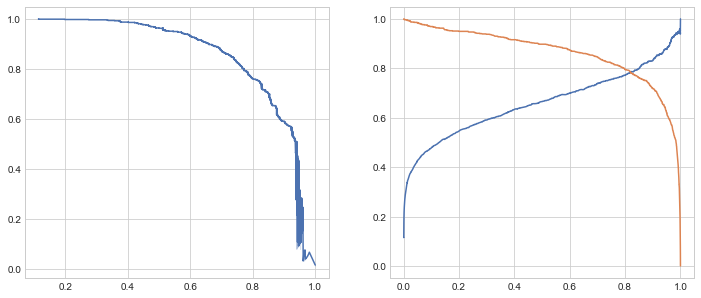

In [17]:
model_cat = catb.CatBoostClassifier(loss_function='Logloss',
                                verbose=True,
                                scale_pos_weight=20,
                                thread_count=20,
                                max_depth=4, 
                                learning_rate=0.1, 
                                n_estimators=1000,
                                reg_lambda=10)

df_ERA_feature_importances = fit_clf_on_all_features(model_cat)

In [18]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg)

[15:26:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:14] INFO: /workspace/src/tree/upd

[15:27:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:58] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=20, nthread=20, num_parallel_tree=1,
              random_state=1337, reg_alpha=100.0, reg_lambda=1.0,
              scale_pos_weight=20.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

# Reduce dataframe to most important features

In [574]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:30, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [575]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
df_ERA_reduced_train = df_ERA_reduced_features.loc[train_mask, feature_names_reduced]
df_ERA_reduced_test = df_ERA_reduced_features.loc[test_mask, feature_names_reduced]
quantile_scaler_ERA.fit(df_ERA_reduced_train)
df_ERA_reduced_features_scaled_train = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_train), columns = feature_names_reduced, index=df_ERA_reduced_train.index)
df_ERA_reduced_features_scaled_test = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_test), columns = feature_names_reduced, index=df_ERA_reduced_test.index)

df_ERA_reduced_features_scaled = pd.concat([df_ERA_reduced_features_scaled_train, df_ERA_reduced_features_scaled_test], axis=0).sort_index()
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# PCA

[0.48827122 0.1627074  0.10806673 0.05528474 0.0340668  0.03168506
 0.02145181 0.02087073 0.0187018  0.01355833]


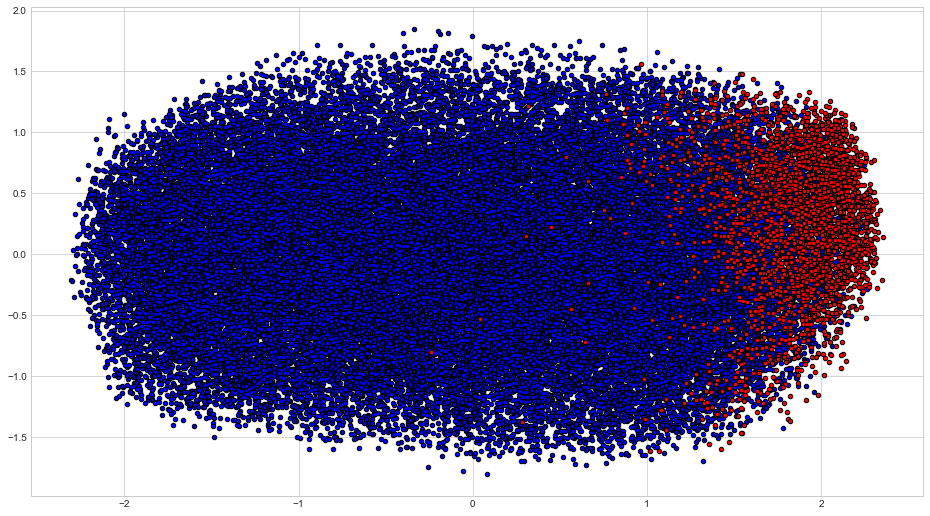

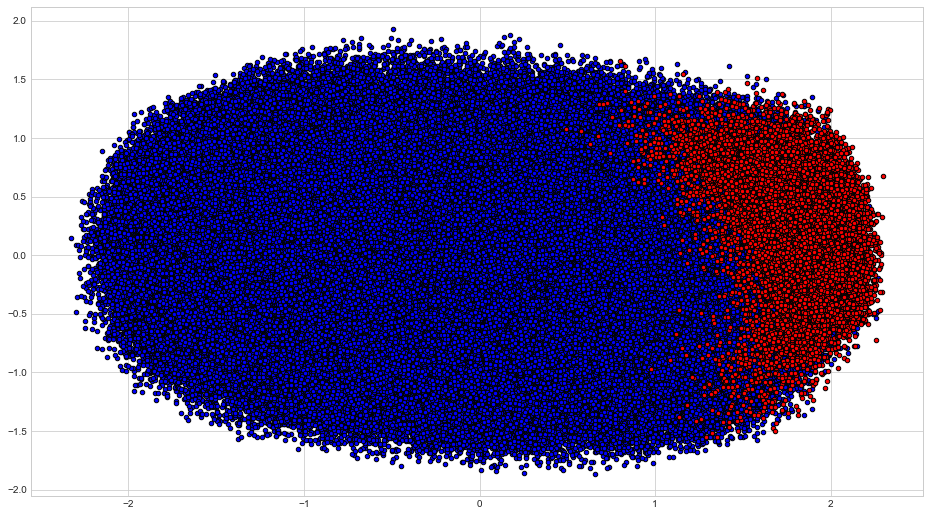

In [252]:
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced])

print(pca.explained_variance_ratio_)

samples_PCA_transformed = pca.transform(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])
samples_CESMp_PCA_transformed = pca.transform(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])

component_1 =0
component_2 =1
plt.figure(figsize=(16,9))

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_2 ], 
            c="blue",
            s=20, 
            edgecolor='k')

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_2 ], 
            c="red",
            s=20, 
            edgecolor='k')

plt.figure(figsize=(16,9))

plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_1 ], 
            samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_2 ], 
            c="blue",
            s=20, 
            edgecolor='k')

plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_1 ], 
            samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_2 ], 
            c="red",
            s=20, 
            edgecolor='k')








Best threshold: 0.37487320034285043
Precision: 0.7321196358907672
Recall: 0.7311688311688311
[[13560   206]
 [  207   563]]


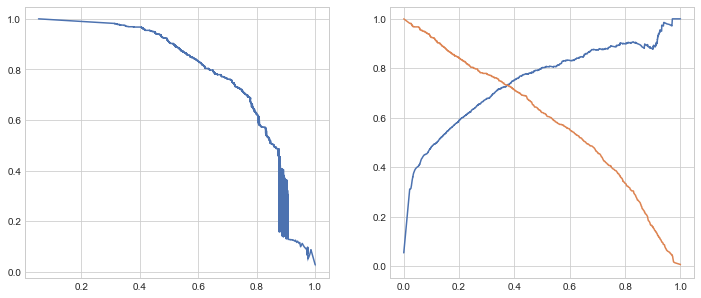

In [46]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30, n_jobs=25, weights="distance")

model.fit(samples_PCA_transformed[train_mask, :], df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])

predictions = model.predict_proba(samples_PCA_transformed[test_mask, :])

precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions[:,1])
best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
predictions = (predictions[:,1]>best_threshold_ERA).astype(int)

# Plot model evaluation curves
f = plt.figure(figsize=(12,5))
f.add_subplot(121)
sns.lineplot(precisions, recalls)
f.add_subplot(122)
sns.lineplot(np.append(thresholds, 1.0), precisions)
sns.lineplot(np.append(thresholds, 1.0), recalls)

# Print model evaluation scores
print(f"Best threshold: {best_threshold_ERA}")
print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions))

# Fit XGBoost to reduced feature set & evaluate

In [381]:
def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
    plt.figure(figsize=(16,9))
    plt.plot(MONTH_NAMES, precision_scores)
    plt.plot(MONTH_NAMES, recall_scores)
    plt.plot(MONTH_NAMES, f1_scores)
    plt.legend(["precision", "recall", "f1-score"])

In [382]:
def get_best_model_through_CV(model, parameters_CV):
    # Fit model
    model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
    model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
                 df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
    print(model_CV.best_params_)
    
    # Predict and optimize threshold
    best_model = model_CV.best_estimator_
    df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
    # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print model evaluation scores
    
    df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
    
    
    precision_scores, recall_scores, f1_scores = [], [], []
    for month in range(1,12+1):
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)

    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
    return best_model, best_threshold_ERA

In [545]:
def train_model_for_each_month(model, parameters):
    models_retrained_list, thresholds_list = [], []
    
    precision_scores, recall_scores, f1_scores = [], [], []
    
    plt.figure(figsize=(16,9))
    for month in range(1,12+1):
        # Define train and test masks
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
        # CV
#         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
#         print(model.get_params())
        model_CV = GridSearchCV(model, parameters, cv=3, n_jobs=4, scoring='neg_log_loss')
        model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
                     df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])

        # Get feature importance
#         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
        # Optimize threshold
        best_model = model_CV.best_estimator_
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
        
        # Retrain model on full data
        best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
                       df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
        models_retrained_list.append(best_model)
        thresholds_list.append(best_threshold_ERA)
        
    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    return models_retrained_list, thresholds_list

Best threshold: 0.8110671830110088
Precision: 0.671875
Recall: 0.6615384615384615
[[1143   21]
 [  22   43]]
Best threshold: 0.35623145124401845
Precision: 0.7796610169491526
Recall: 0.7666666666666667
[[1057   13]
 [  14   46]]
Best threshold: 0.6301063447548881
Precision: 0.7192982456140351
Recall: 0.7068965517241379
[[1158   16]
 [  17   41]]
Best threshold: 0.7614139483881583
Precision: 0.8175182481751825
Recall: 0.8115942028985508
[[1033   25]
 [  26  112]]
Best threshold: 0.7954407827526486
Precision: 0.7064220183486238
Recall: 0.7
[[1092   32]
 [  33   77]]
Best threshold: 0.7500220420965237
Precision: 0.6153846153846154
Recall: 0.6
[[1142   15]
 [  16   24]]
Best threshold: 0.7882430526347443
Precision: 0.7692307692307693
Recall: 0.7142857142857143
[[1209    3]
 [   4   10]]
Best threshold: 0.3355726369421838
Precision: 0.5909090909090909
Recall: 0.5652173913043478
[[1207    9]
 [  10   13]]
Best threshold: 0.4485559587189668
Precision: 0.7258064516129032
Recall: 0.714285714285

<Figure size 1152x648 with 0 Axes>

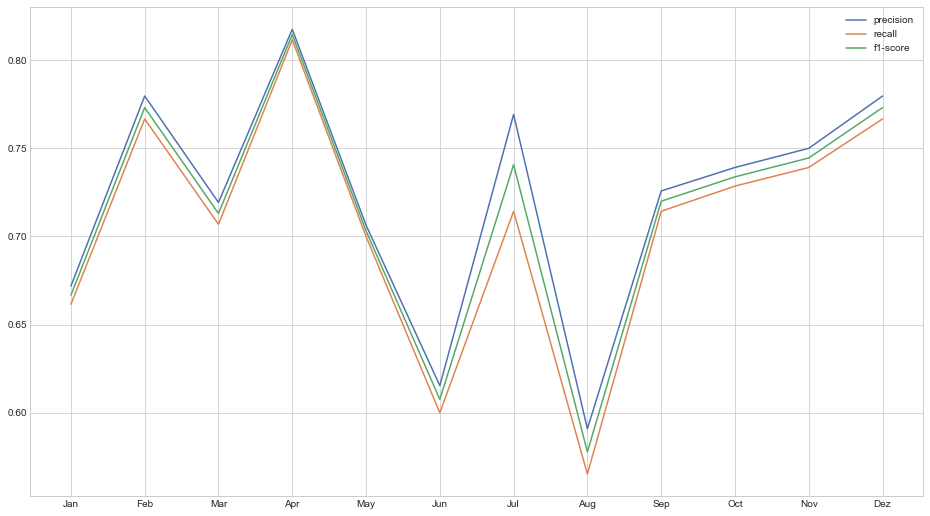

In [600]:
monthly_models = 1
estimator = "CGB" # XGB, CATB, LGB, or KNN

## XGBoost estimator
if estimator == "XGB":
    model = xgb.XGBClassifier(
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    verbosity=0,
                    nthread=5,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )


    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000], "reg_alpha":[10], "reg_lambda":[10] }

## CatBoost estimator
elif estimator == "CGB":
    model = catb.CatBoostClassifier(loss_function='Logloss',
                                    verbose=False,
                                    scale_pos_weight=20,
                                    thread_count=5,
                                    random_seed=42)

    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000]}

## LightGBM estimator
elif estimator == "LGB":
    model = lgb.LGBMClassifier(loss_function='Logloss',
                               boosting_type="goss",
                                    verbose=0,
                                    scale_pos_weight=20,
                                    n_jobs=5,
                                    random_seed=42)

    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000]}

## KNN estimator
elif estimator == "KNN": 
    model = sklearn.neighbors.KNeighborsClassifier(n_jobs=8,weights="distance")
    parameters = {'n_neighbors': [30,50]}

# Monthly or yearly model
if monthly_models:
    models_retrained_list, thresholds_list = train_model_for_each_month(model, parameters)
else:
    model, best_threshold_ERA = get_best_model_through_CV(model, parameters)
#     model.set_params(n_jobs=25)
    
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"


# Load CESM data 

In [26]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [27]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [28]:
# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

In [601]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

# Transform features to quantiles on CESM

In [602]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Predict on CESMp and CESMf

In [603]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = models_retrained_list[month-1].predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])[:,1]
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)

        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = models_retrained_list[month-1].predict_proba(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])[:,1]
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
else:
    df_CESMp_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMp_reduced_features_scaled["prediction"] = (df_CESMp_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
    df_CESMf_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMf_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMf_reduced_features_scaled["prediction"] = (df_CESMf_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)

df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [604]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [605]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled, 
                                      df_CESMp_reduced_features_scaled, 
                                      df_CESMf_reduced_features_scaled], 
                                     axis=0, 
                                     ignore_index=True)

In [606]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [607]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [608]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [609]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

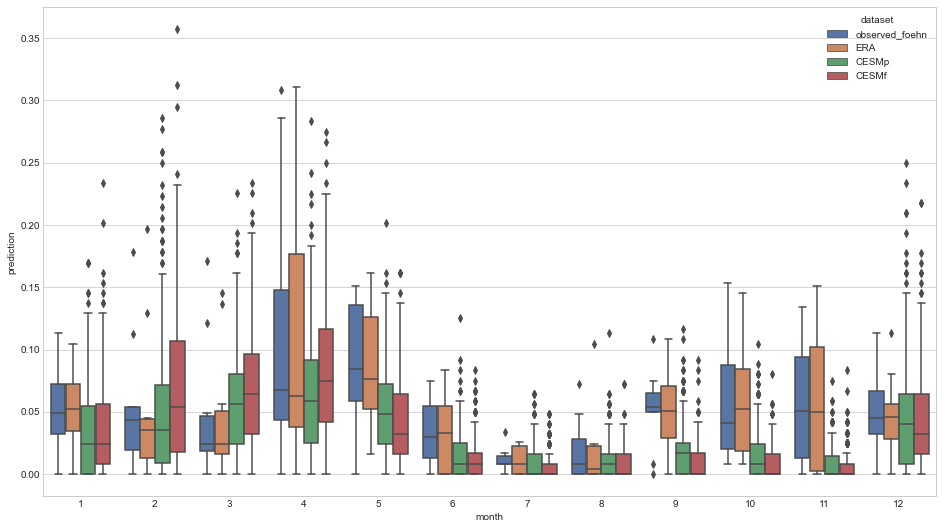

In [610]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])

# Second statistical test

(0.0, 0.3)

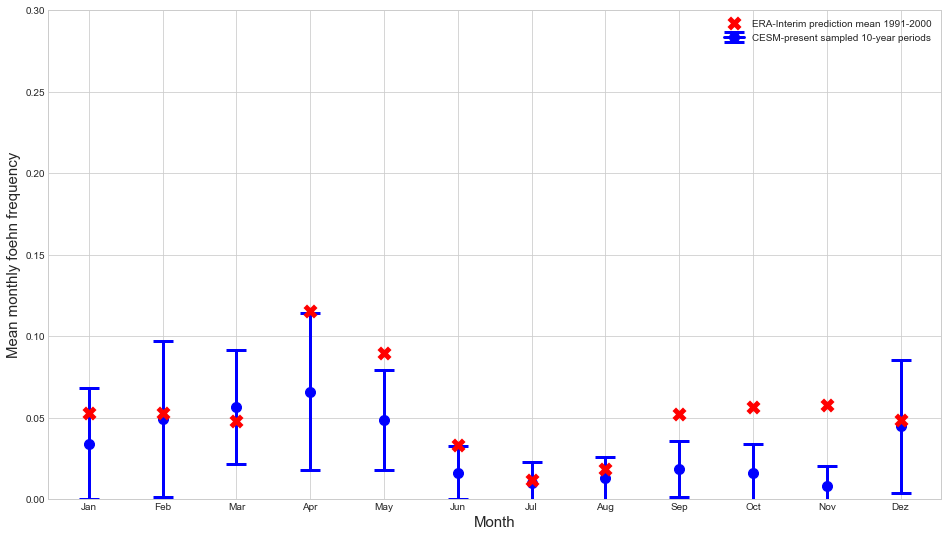

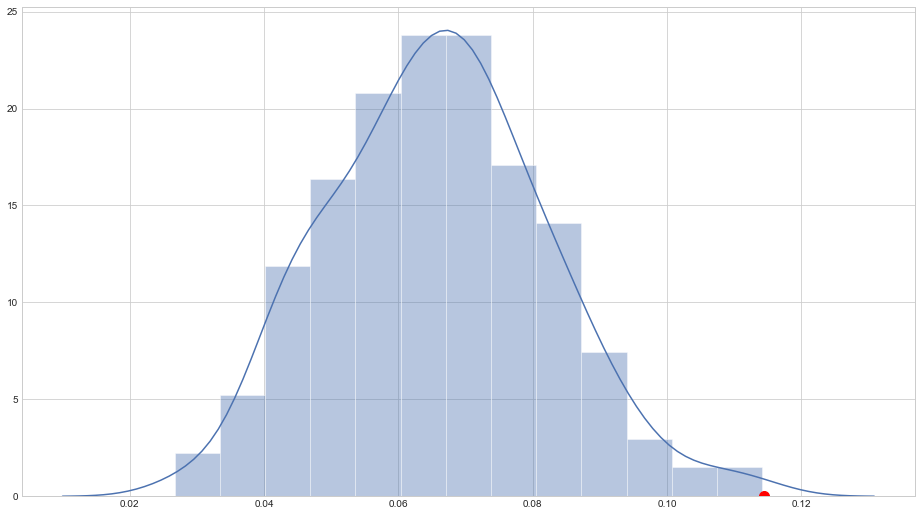

In [611]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(200):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["ERA-Interim prediction mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.30))


# Third statistical test

In [612]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.94271	False
Feb	3e-05	True
Mar	0.00156	True
Apr	1e-05	True
May	0.00787	True
Jun	0.00609	True
Jul	0.00034	True
Aug	1e-05	True
Sep	0.0	True
Oct	3e-05	True
Nov	0.98649	False
Dez	0.99886	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

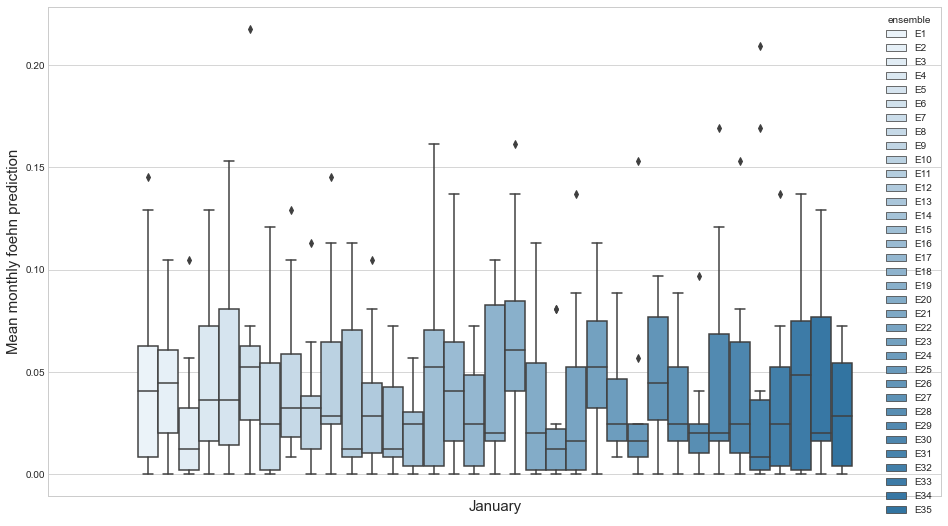

In [233]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)